### Data Assimilation into WOFOST model ### 

In [1]:
%matplotlib inline
import sys, os
import copy
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pcse.fileinput import CABOFileReader, YAMLCropDataProvider, CABOWeatherDataProvider,YAMLAgroManagementReader, ExcelWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.models import Wofost71_WLP_FD, Wofost71_PP

import ipywidgets.widgets as widgets
from ipywidgets import interact, interactive, fixed
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data_dir = os.path.join(os.getcwd(), "data")

agromanagement_contents = """
Version: 1.0
AgroManagement:
- {year:d}-01-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: '{variety}'
        crop_start_date: {crop_start_date}
        crop_start_type: sowing
        crop_end_date: {crop_end_date}
        crop_end_type: harvest
        max_duration: 150
    TimedEvents: null
    StateEvents: null
"""
WOFOST_PARAMETERS = ['DVS', 'LAI', 'TAGP', 'TWSO', 'TWLV', 'TWST',
                'TWRT', 'TRA', 'RD', 'SM']
LABELS = ["Development stage [-]", "LAI [m2/m2]",
                 "Total Biomass [kg/ha]",
                 "Total Storage Organ Weight [kg/ha]",
                 "Total Leaves Weight [kg/ha]",
                 "Total Stems Weight [kg/ha]",
                 "Total Root Weight [kg/ha]",
                 "Transpiration rate [cm/d]",
                 "Rooting depth [cm]",
                 "Soil moisture [cm3/cm3]"]
WOFOST_LABELS = dict(zip(WOFOST_PARAMETERS, LABELS))

In [3]:
def set_up_wofost(crop_start_date, crop_end_date,
                  meteofile, crop, variety, soil,
                  wav=10, co2=360, rdmsol=100.):
    cropdata = YAMLCropDataProvider(os.path.join(data_dir, "crop"))
    cropdata.set_active_crop(crop, variety)
    soilfile = os.path.join(data_dir, 'soil', soil)
    soildata = CABOFileReader(soilfile)
    soildata['RDMSOL'] = rdmsol
    sitedata = WOFOST71SiteDataProvider(WAV=wav, CO2=co2)
    parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)
    with open("temporal.amgt", 'w') as fp:
        fp.write(agromanagement_contents.format(year=crop_start_date.year,
                        crop=crop, variety=variety, crop_start_date=crop_start_date,
                        crop_end_date=crop_end_date))
    agromanagement = YAMLAgroManagementReader("temporal.amgt")

    meteo = os.path.join(data_dir, 'meteo', meteofile)
    wdp = ExcelWeatherDataProvider(meteo)
    return parameters, agromanagement, wdp

def run_wofost(parameters, agromanagement, wdp, potential=False):
    if potential:
        wofsim = Wofost71_PP(parameters, wdp, agromanagement)
    else:        
        wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
    print(parameters)
    wofsim.run_till_terminate()
    df_results = pd.DataFrame(wofsim.get_output())
    df_results = df_results.set_index("day")
    return df_results, wofsim

## 1. The model and the observations

### 1.1. A standard WOFOST run

First we make a standard WOFOST run for a soybean crop to see the model behaviour without assimilation of satellite data.

In [4]:
crop_start_date = dt.date(2020, 9, 15)
crop_end_date = dt.date(2021, 1, 12)
meteofile = 'chwele.xls'
crop = 'soybean'
variety = 'Soybean_901'
soil = 'M04.AWC'

parameters, agromanagement, wdp = set_up_wofost(crop_start_date, crop_end_date,
                  meteofile, crop, variety, soil,)
df_results, simulator = run_wofost(parameters, agromanagement, wdp,
                                           potential=False)

ParameterProvider providing 111 parameters, 0 parameters overridden: dict_keys([]).


### 1.2. The satellite observations
For this exercise, we assume that we have observations on five dates of both leaf area index ("LAI") and volumetric soil moisture ("SM"). Operationally such data could be retrieved from the MODIS LAI product and the soil moisture products from the scatterometer onboard METOP. Next to the observations itself, we have to provide a standard deviation of the estimated value as a measure of accuracy of the observation. 

For this example, we will assume that the LAI estimates have a standard deviation of 5% of the estimated value. The latter is very accurate compared to the accuracy reached by typical satellite LAI products which is more in the order of 20%. For the soil moisure observations we assume a standard deviation of 20% of the simulated value. 

In [5]:
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2020,10,2), dt.date(2020,10,27), dt.date(2020,11,19), 
                        dt.date(2020,12,4), dt.date(2020,12,28)]
observed_lai = np.array([0.2, 0.5, 0.6, 1.1, 0.7])
std_lai = observed_lai * 0.05 # Std. devation is estimated as 5% of observed value                                                                 
observed_sm = np.array([0.24, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.2 # Std. devation is estimated as 20% of observed value
observations_for_DA = []

# Pack them into a convenient format
for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm):
    observations_for_DA.append((d, {"LAI":(lai, errlai), "SM":(sm, errsm)}))

### 1.1.3. Plot modelled and observed states
We will now combine the default WOFOST run and the satellite observations in a single figure.

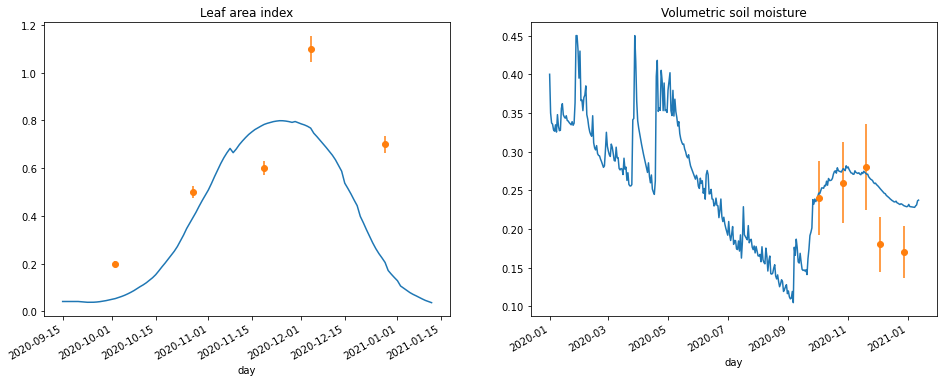

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
df_results.LAI.plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df_results.SM.plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()

## 1.3. Setting up the ensemble

### 1.3.1 The size of the ensemble
First we define the size of the ensemble, tests have demonstrated that for crop models like WOFOST an ensemble 
of size 50 is sufficient to represent the uncertainty in the model. Next, we set the random seed in order to have a reproducible sequence of random numbers. 

In [7]:
ensemble_size = 50
np.random.seed(10000)

### 1.3.2 Defining variability in the ensemble

The purpose of the ensemble is to represent uncertainty in the simulated states. Therefore, we have to think carefully how we will generate the ensemble in order to have a representative amount of variability within the ensemble. In practice, this means that we have to enforce uncertainty on parameters, weather data and/or agromanagement. 

Choosing the most uncertain parts of your system is not straightforward and differs from case to case. For studies at field scale and with local weather data available, it is most likely that most of the variability comes from uncertainty in the parameter values or even in the model structure (not treated here). For regional applications, it is more likely that uncertainty in weather inputs as well as soil data and agromanagement (unknown sowing dates) play a major role. 

A sensitivity analysis (SA) of the model can be helpful in identifying uncertain parameters, however SA should be applied carefully as it can easily lead to wrong conclusions particularly if boundaries of parameters are poorly choosen.

For the purpose of this tutorial we will assume that uncertainty is in the following model parameters:
 - Initial conditions like the initial biomass (TDWI) and initial soil water amount (WAV).
 - parameters values like the life span of leaves (SPAN) and the field capacity of the soil (SMFCF)
 
These four parameters will be treated as a Gaussian random variables with a mean equal to the default value and a standard deviation which is guessed from experience with the model. Each ensemble member will receive a value for the respective parameter which is drawn from the distribution of each parameter and this value will override the default value.

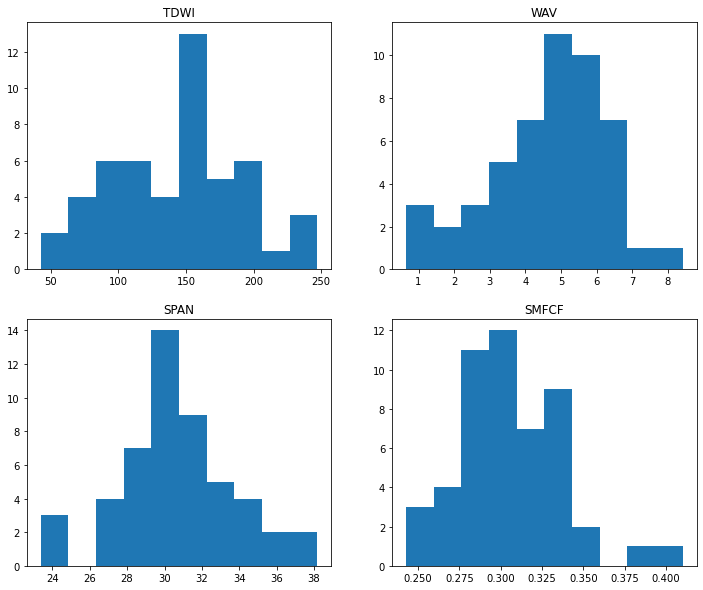

In [8]:
# A container for the parameters that we will override
override_parameters = {}
#Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

## 1.3.3 Initializing the ensemble

The python code below initializes an ensemble of WOFOST models which are collected in the list named `ensemble`. Each ensemble member receives distinct values for the four parameters defined above, all other parameters are equal for all ensemble members. Note that after the initialization step, no simulation has been carried out. All members are waiting in their initial state and need to be instructed explicitly to carry out the actual simulation.

In [9]:
agromanagement_file = os.path.join(data_dir, 'agro', 'lintul3_soybeans_calendar.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
weatherfile = os.path.join(data_dir, 'meteo', 'chwele.xls')
weather = ExcelWeatherDataProvider(weatherfile)

In [10]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost71_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

## 1.4. Implementing the data assimilation itself
First, we define if we want to see detailed output, disabling output makes the notebook more compact as long tables will not be shown.

In [11]:
show_output = False

### 1.4.1 Move the ensemble forward in time until the first analysis step
First we take the first observation from the set of observations. Next, we will instruct each ensemble member to move forward in time (simulate the crop) up till the date where the first observation is available. The latter is done with the `run_till()` function on each member.

In [12]:
day, obs = observations_for_DA.pop(0)
for member in ensemble:
    member.run_till(day)
print("%s observations left!" % len(observations_for_DA))

4 observations left!


All ensemble members should now have reached the day where we have an observations:

### 1.4.2 Retrieve the states from the ensemble
All ensemble members have now reached the date of the first observation. We will now collect the simulated leaf area index (LAI) and soil moisture (SM) from the ensemble and collect them in the list `collected_states`. We will then convert the list  into a pandas dataframe `df_A` which will be converted to the matrix $A$. The dataframe `df_A` is for visualising the results while the matrix $A$ will be used for mathematical operations.

In [14]:
collected_states = []
for member in ensemble:
    t = {}
    for state in variables_for_DA:
        t[state] = member.get_variable(state)
    collected_states.append(t)
df_A = pd.DataFrame(collected_states)
A = np.matrix(df_A).T
df_A if show_output else None

### 1.4.3 Compute covariance within ensemble states

In order to compute the Kalman gain we need to calculate the (co)variance matrix of the simulated states within the ensemble.  This can be easily accomplished with the `cov()` function on the pandas dataframe. By convention we call the covariance matrix $P_e$.

In [15]:
P_e = np.matrix(df_A.cov())
df_A.cov() if show_output else None

### 1.4.4. Calculate perturbed observations and their mean and covariance

The purpose of the simulated ensemble is to treat the simulated states as a random variable. In the same way, we need to treat the observed states as a random variable. We can accomplish this by generating a distribution of perturbed observations with a mean and standard deviation defined by the observed value and its uncertainty. 

In this code, the perturbed observations are first collectected in the dataframe `df_perturbed_obs` which is then converted in the matrix $D$ and its covariance matrix $R_e$.



In [16]:
perturbed_obs = []
for state in variables_for_DA:
    (value, std) = obs[state]
    d = np.random.normal(value, std, (ensemble_size))
    perturbed_obs.append(d)
df_perturbed_obs = pd.DataFrame(perturbed_obs).T
df_perturbed_obs.columns = variables_for_DA
D = np.matrix(df_perturbed_obs).T
R_e = np.matrix(df_perturbed_obs.cov())
df_perturbed_obs if show_output else None

### 1.4.5 Apply the Kalman filter equations
First we compute the Kalman gain $$K = \frac{P_e H^T}{(H P_e H^T + R_e)}$$

The Kalman gain weights the uncertainty of the simulated values (by its variance $P_e$) against the uncertainty of the observations (by its variance $R_e$). Here, $H$ is the *measurement operator* (also called *observation matrix*) which specifies the (linear) relationship between the simulated state and the observed quantity. In our case, $H$ is an identity matrix because LAI and SM are observed directly and no conversion from state to observation is needed.

Next we compute the Kalman state updates:
$$A^a = A + K (D - H A)$$

Here the matrix with updated values of the states $A^a$ (also called the *analysed* states) is computed by augmenting the old states $A$ with the difference between the observed $D$ and simulated $A$ values multiplied by the Kalman gain $K$. The part of the equation $K (D - H A)$ is called the *innovations*.

The impact of the Kalman gain is most easily understood from the extreme cases for a single state. Let's first assume that the simulation is perfect, this implies that the variance $P_e$ is zero as the numerator is zero. In that case, the obervations are totally ignored because Kalman gain is zero and the analysed states $A^a$ are equal to the simulated states because the innovations are zero. The other extreme cases is when we assume that the observations are perfect and have variance $R_e$ of zero. In this case, the Kalman gain is '1' and the innovations are such that the analysed state $A^a$ is augmented to exactly match the observations.

In [17]:
# Here we compute the Kalman gain
H = np.identity(len(obs))
K1 = P_e * (H.T)
K2 = (H * P_e) * H.T
K = K1 * ((K2 + R_e).I)
K if show_output else None

In [18]:
# Here we compute the analysed states
Aa = A + K * (D - (H * A))
df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
df_Aa if show_output else None

### 1.4.6 Update the ensemble to reflect the new state
We have computed the new states for each ensemble member which are collected in the dataframe `df_Aa`. We now need to update each WOFOST ensemble member to update its internal state to the value in `df_Aa`. This update is done with the `set_variable(<varname>, <value>)` method that is available on each WOFOST object. 

Note that *setting* a variable is much more difficult than *getting* a variable because in order to change an internal state it is often required to change other related states as well. For example, LAI in WOFOST is not a true state but a state which is derived from the leaf biomass. In order to update the LAI we need to update the leaf biomass as well. Similarly, for updating soil moisture it is not only required to update the volumetric water contect in the rooted zone, but also the amount of water in the root zone. Moreover, some of the totals need to be adapted in order to have a closing water balance. This means that the logic for state updates is highly depending on the particular model structure and needs to be implemented for each state variable individually.

Technically, this is implemented by implementing a object method `_set_variable_<varname>()` that implements all logic to update the state variable `varname`. For example, for LAI updates a method `_set_variable_LAI()` is implemented on the leaf_dynamics module that will be called by the `set_variable` method in order to update the LAI.

In [19]:
for member, new_states in zip(ensemble, df_Aa.itertuples()):
    member.set_variable("LAI", new_states.LAI)
    member.set_variable("SM", new_states.SM)

### 1.4.7 Repeat steps 2.4.1 to 2.4.6 for the next analysis step (observation)

We now need to repeat the above steps for each observation available and until the cell under 2.4.1 reports `0 observations left!`

*Tip*: You can switch of the output in order to have a more compact notebook.


### 1.4.8 Run all the ensemble members until the end of the growing season

Finally, we can run the WOFOST ensemble until the end of the growing season using the `run_till_terminate()` call.

In [21]:
for member in ensemble:
    member.run_till_terminate()

# 2. Visualizing output from the ensemble with the EnKF
## 2.1 Retrieve output from the ensemble

First we retrieve the simulated output from each ensemble member and convert it into a dataframe.

In [22]:
results = []
for member in ensemble:
    member_df = pd.DataFrame(member.get_output()).set_index("day")
    results.append(member_df)

## 2.2 Visualize ensemble with EnKF

Now we plot the simulated output for the variables LAI and SM for each ensemble member into a graph. This clearly shows the impact of the observations on the simulated value. At each time step where an observation of LAI is available, the uncertainty in the ensemble is strongly reduced as is demonstrated from the reduction of the variability in the simulated ensemble.

**WARNING**: Setting a variable for soil moisture is not yet implemented for PCSE/WOFOST so the impact of DA on soil moisture is not showing in the graphs!!

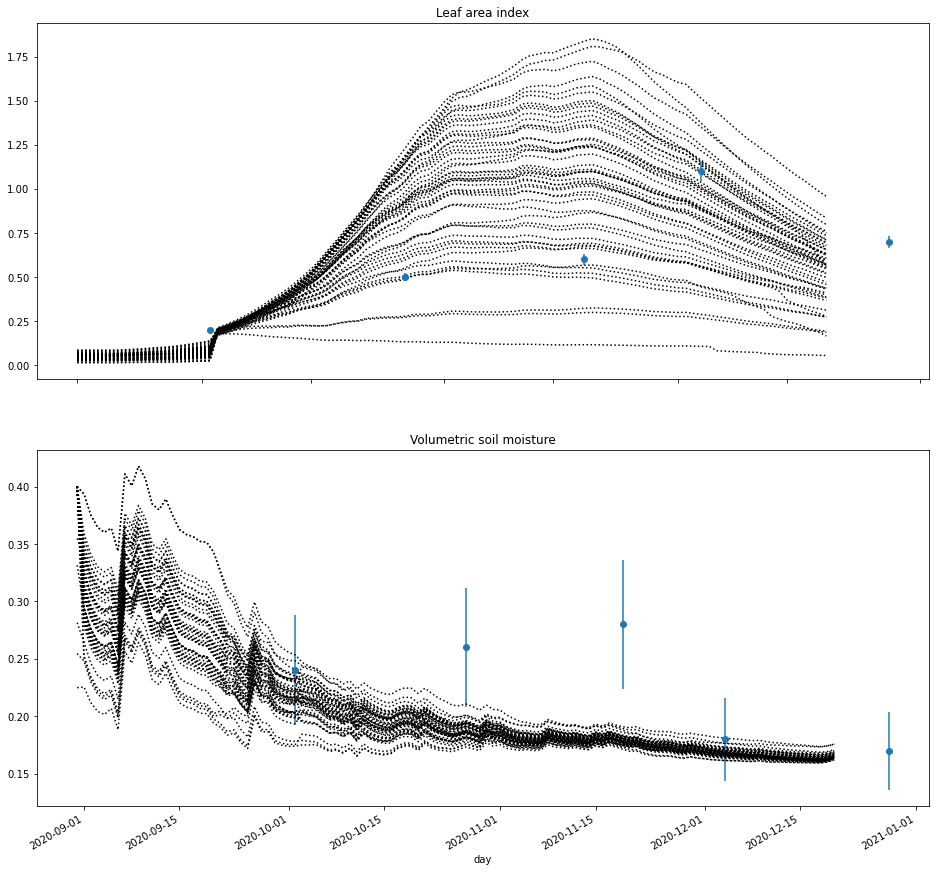

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16))
for member_df in results:
    member_df["LAI"].plot(style="k:", ax=axes[0])
    member_df["SM"].plot(style="k:", ax=axes[1])
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()